In [23]:
import os
print(os.listdir("."))

# Authorization for Google Colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Mount drive to "drive/" folder
!fusermount -u drive
!mkdir -p drive
#except:
#  pass
!google-drive-ocamlfuse drive

# Change Working directory
print(os.listdir("drive/variable-classifier/NN/periodicnetwork-master/"))
os.chdir("drive/variable-classifier/NN/periodicnetwork-master/")
print(os.listdir("."))

['.config', 'drive', 'sample_data']
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3

In [38]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import joblib
import re
from collections import OrderedDict

In [92]:
data = 'ogle'
filename = 'data/ogle_data_15.pkl'
classnames = 'data/ogle_class_names_15.txt'
unitsphere = 'data/ogle_15.unitsphere.pickle'

unique_labels = OrderedDict()
with open(classnames) as class_list:
    for c in class_list:  
        num, classname = c.strip().split()
        if 'macho' in filename:
            classname = classname.replace("_"," ")
        unique_labels[classname] = None 
unique_label, count = np.unique(list(unique_labels.keys()), return_counts=True) 
ind2label = dict(zip(np.arange(len(unique_label)), unique_label))

data =  joblib.load(filename)
unique_label, count = np.unique([lc.label for lc in data], return_counts=True)
use_label = unique_label[count >= 0]
ind2label2 = dict(zip(np.arange(len(use_label)), use_label))

In [93]:
def cm(predtruth, seperator, labels='all'):
  pred, truth = [], []
  for maxset in range(len(predtruth)):
    for k in range(len(predtruth[maxset][0][:seperator][0])):
      for j in predtruth[maxset][0][:seperator][0][k]:
        if labels=='used':
          pred.append(ind2label2[j])
        else:
          pred.append(ind2label[j])
    for k in range(len(predtruth[maxset][0][seperator:seperator+1][0])):
      for j in predtruth[maxset][0][seperator:seperator+1][0][k]: 
        if labels=='used':
          truth.append(ind2label2[j])
        else:
          truth.append(ind2label[j])
  y_actu = pd.Series(truth, name='Actual')
  y_pred = pd.Series(pred, name='Predicted')
  return pd.crosstab(y_actu, y_pred, normalize='index')

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

def make_table(eval):
    tanimoto, heights, pathlengths, similarities, true_similarities = eval[0][:8],eval[0][8:16],eval[0][16:24],eval[0][24:32],eval[0][32:40]
    metric = ['tanimoto','height','pathlength','similarity','true_similarity']
    data = [tanimoto, heights, pathlengths, similarities, true_similarities]
    data = np.asarray(data).reshape((5,8))
    df=pd.DataFrame(columns=['mean', 'med', 'min','max','1','5','95','99'], data=data)
    df.insert(loc=0, column='metric', value=metric)
    return df

def find_sims(probs, truth, alllabels=True, cos=False, wrong=False):
  label2int, int2label, unique_labels = {}, {}, OrderedDict()
  with open(classnames) as class_list:
      for c in class_list:  
          num, classname = c.strip().split()
          label2int[classname] = int(num) 
          int2label[int(num)] = classname
          unique_labels[classname] = None 
  with open(unitsphere, 'rb') as pf:
      embedding = pickle.load(pf)
      linear_labels = embedding['label2ind'] 
      embed_labels = embedding['ind2label']
      embedding = embedding['embedding']

  unique_label, count = np.unique(list(unique_labels.keys()), return_counts=True) 
  convert_label = dict(zip(unique_label, np.arange(len(unique_label))))
  convert_emb2ind = lambda i: convert_label[int2label[embed_labels[i]]] 
  i2l = ind2label if alllabels else ind2label2

  def find_similarity(prediction, ground_truth): 
    return np.matmul(embedding[linear_labels[label2int[i2l[prediction]]]].T,embedding[linear_labels[label2int[i2l[ground_truth]]]])

  sim_list = []
  preds = []
  for p in range(len(probs)):
    if not np.any(np.isnan(np.asarray(probs[p]))):
      all_sims = []
      pre_list = []
      for i in range(len(probs[p])):
        max_index, max_value = max(enumerate(probs[p]), key=lambda pair: pair[1])
        probs[p][max_index] = -1
        if cos: 
          pre = convert_emb2ind(max_index)
        else: 
          pre = max_index
        if truth[p] not in pre_list:
          pre_list.append(pre)
          sim = find_similarity(pre, truth[p])
          all_sims.append(sim)
        else: 
          all_sims.append(np.nan)
      if True:#not wrong or truth[p] not in pre_list[:5]:
        preds.append(pre_list[:9])
        sim_list.append(all_sims)
  mean_sim = np.nanmean(sim_list, axis=0)
  return mean_sim, preds

In [50]:
dataset = filename.split("/")[1].split(".")[0]
extra = ''
maxes = [150,100,75,50,25,10]
cacc, hacc, oacc = [],[],[]
c_predtruth, h_predtruth, o_predtruth = [],[],[]
c_eval, h_eval, o_eval = [],[],[]
maxsize, minsize = str(100), str(60)
for i in range(len(maxes)):
  maxsize = str(maxes[i])
  '''c_res = np.load('results/cosine/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLcosine-MS'+maxsize+'-results-class.npy',allow_pickle=True)
  c_res2 = np.load('results/cosine/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLcosine-MS'+maxsize+'-results.npy',allow_pickle=True)
  cacc.append(c_res[0][1])
  c_predtruth.append(np.load('results/cosine/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLcosine-MS'+maxsize+'-results-predtruth.npy', allow_pickle=True))
  c_eval.append(np.load('results/cosine/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLcosine-MS'+maxsize+'-results-eval.npy', allow_pickle=True))
  c_raweval = np.load('results/cosine/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLcosine-MS'+maxsize+'-results-raweval.npy', allow_pickle=True)'''

  h_res = np.load('results/small_data_3data/hidden/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLhidden-MS'+maxsize+'-results-class.npy',allow_pickle=True)
  h_res2 = np.load('results/small_data_3data/hidden/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLhidden-MS'+maxsize+'-results.npy',allow_pickle=True)
  hacc.append(h_res[0][1:])
  h_predtruth.append(np.load('results/small_data_3data/hidden/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLhidden-MS'+maxsize+'-results-predtruth.npy', allow_pickle=True))
  h_eval.append(np.load('results/small_data_3data/hidden/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLhidden-MS'+maxsize+'-results-eval.npy', allow_pickle=True))
  h_raweval = np.load('results/small_data_3data/hidden/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-CLhidden-MS'+maxsize+'-results-raweval.npy', allow_pickle=True)

  og_res = np.load('results/small_data_3data/original/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-MS'+maxsize+'-results-class.npy',allow_pickle=True)
  og_res2 = np.load('results/small_data_3data/original/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-MS'+maxsize+'-results.npy',allow_pickle=True)
  oacc.append(og_res[0][1:])
  o_predtruth.append(np.load('results/small_data_3data/original/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-MS'+maxsize+'-results-predtruth.npy',allow_pickle=True))
  o_eval.append(np.load('results/small_data_3data/original/'+dataset+'-iresnet-K7-D5-NL2-H16-MH32-L200-V0-dtf-LR0.005-CLIP32-DROP0-TP0-MS'+maxsize+'-results-eval.npy',allow_pickle=True))

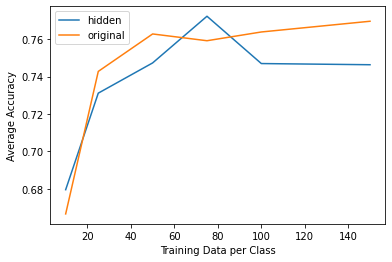

In [51]:
#plt.plot(maxes, cacc, label='cosine')
plt.plot(maxes, np.mean(hacc,axis=-1), label='hidden')
plt.plot(maxes, np.mean(oacc,axis=-1), label='original')
plt.xlabel("Training Data per Class")
plt.ylabel("Average Accuracy")
plt.legend()
plt.show()

In [86]:
#c_df_confusion = cm(c_predtruth, 1)
h_df_confusion = cm(h_predtruth, 1)
o_df_confusion = cm(o_predtruth, 1, labels='used')

Text(0.5, 1.0, 'Old Loss')

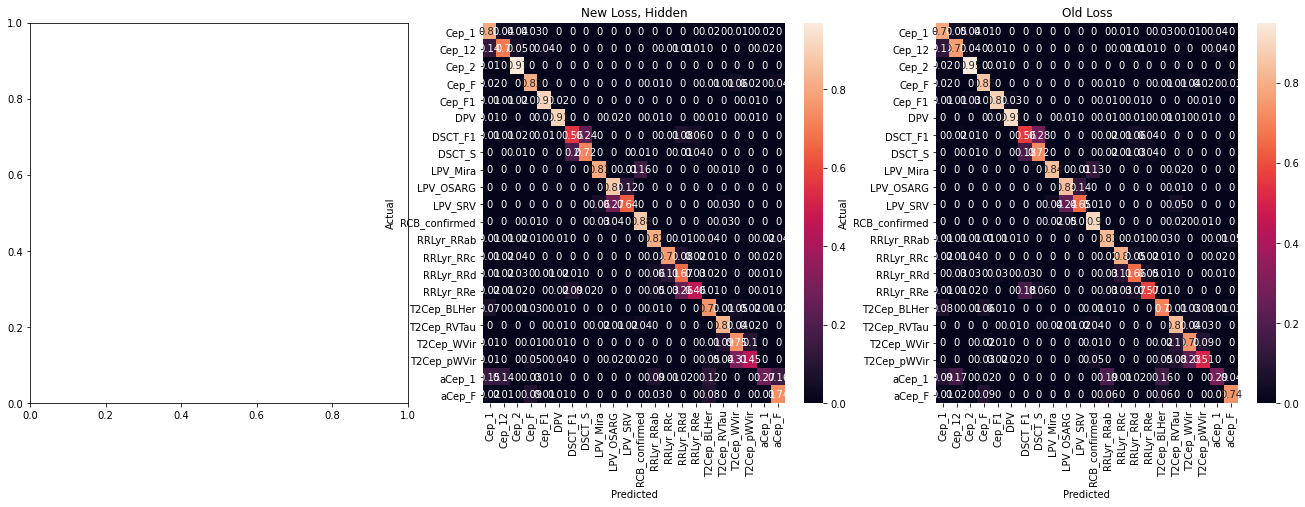

In [91]:
def cm_round():
  r = lambda x: round(x, 2)
  return r

#c_df_confusion=c_df_confusion.applymap(cm_round())
h_df_confusion=h_df_confusion.applymap(cm_round())
o_df_confusion=o_df_confusion.applymap(cm_round())

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(23,7))
#g1 = sn.heatmap(c_df_confusion, annot=True,ax=ax1)
#ax1.set_title("New Loss, Cosine")
g2 = sn.heatmap(h_df_confusion, annot=True,ax=ax2)
ax2.set_title("New Loss, Hidden")
g3 = sn.heatmap(og_df_confusion, annot=True,ax=ax3)
ax3.set_title("Old Loss")

In [98]:
#c_mean_sim, preds1 = find_sims(np.concatenate([c_predtruth[i][0][2][0] for i in range(5)]),np.concatenate([c_predtruth[i][0][1][0] for i in range(5)]),cos=True,wrong=False)
h_mean_sim, predsh1 = find_sims(np.concatenate([h_predtruth[i][0][2][0] for i in range(5)]),np.concatenate([h_predtruth[i][0][1][0] for i in range(5)]),wrong=False)
o_mean_sim, preds = find_sims(np.concatenate([o_predtruth[i][0][2][0] for i in range(5)]),np.concatenate([o_predtruth[i][0][1][0] for i in range(5)]), alllabels=False, wrong=False)

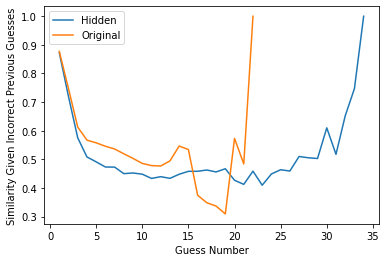

In [99]:
x = np.linspace(1,len(h_mean_sim),len(h_mean_sim))
plt.plot(x,h_mean_sim,label="Hidden")
#x = np.linspace(1,len(c_mean_sim),len(c_mean_sim))
#plt.plot(x,c_mean_sim,label="Cosine")
x = np.linspace(1,len(o_mean_sim),len(o_mean_sim))
plt.plot(x,o_mean_sim,label="Original")
plt.xlabel("Guess Number")
plt.ylabel("Similarity Given Incorrect Previous Guesses")
plt.legend()